In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/10708\ Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/14Gdouwq1YbxwJPoIAfI-AnPNaIq3hw2L/10708 Project


In [2]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import re
import torch
import torch.nn as nn
from collections import Counter
import tqdm
import random
import pickle
from nltk.tokenize import wordpunct_tokenize
from sklearn.metrics import confusion_matrix, accuracy_score

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)


class Model(nn.Module):
    def __init__(self, embed_dim=128, gru_out=128, z_dim=1):

        super(Model, self).__init__()
        self.embed_dim = embed_dim
        self.gru_out = gru_out
        self.z_dim = z_dim

        self.gru = nn.Sequential(
            nn.Embedding(2000, embed_dim),
            nn.GRU(embed_dim, gru_out, bidirectional=True, batch_first=True),
        )

        self.classifier = nn.Linear((2*gru_out)+z_dim, 1)

    def forward(self, x, z):
        x = self.gru(x)[1].transpose(0, 1).contiguous().view((x.shape[0], -1))
        assert(x.shape == (z.shape[0], self.gru_out*2))
        x = torch.cat((x, z), dim=1)
        x = self.classifier(x)
        return x

    def forward_all_z(self, x, all_z, p_z):
        batch_size = x.size(0)
        x = self.gru(x)[1].transpose(0, 1).contiguous().view((x.shape[0], -1))

        output = torch.zeros((batch_size, 1)).cuda()
        model_outputs = []
        for p_zi, z_val in zip(p_z, all_z):
            z_val = torch.unsqueeze(z_val, 0).repeat((batch_size, 1))
            x_z = torch.cat((x, z_val), dim=1)
            model_out_z = self.classifier(x_z)
            model_out_z = torch.sigmoid(model_out_z)
            output += p_zi.item() * model_out_z
            model_outputs.append(model_out_z)

        return output, model_outputs


class BasicModel(nn.Module):
    def __init__(self, embed_dim=128, gru_out=128):

        super(BasicModel, self).__init__()
        self.embed_dim = embed_dim
        self.gru_out = gru_out

        self.gru = nn.Sequential(
            nn.Embedding(2000, embed_dim),
            nn.GRU(embed_dim, gru_out, bidirectional=True, batch_first=True),
        )

        self.classifier = nn.Linear((2*gru_out), 1)

    def forward(self, x):
        x = self.gru(x)[1].transpose(0, 1).contiguous().view((x.shape[0], -1))
        x = self.classifier(x)
        return x


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(X_train, y_train, z_train, model, optimizer, criterion, num_epochs=1, batch_size=256, lr=0.001):
      
    model.train()
    train_size = X_train.shape[0] 

    for epoch in range(num_epochs):

        train_loss_meter = AverageMeter()
        i = 0

        for batch in range(0, train_size, batch_size):

            start_index = batch
            end_index = min(batch + batch_size, train_size)

            batch_X = X_train[start_index:end_index].cuda()
            batch_z = z_train[start_index:end_index].cuda()

            batch_y = y_train[start_index:end_index].cuda()

            output = model(batch_X, batch_z)

            loss = criterion(output, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item(), (end_index-start_index))

            if(i % 100 == 0):
                print("Epoch: {}, Iter: {}, Training Loss: {}".format(epoch, i, train_loss_meter.avg))

            i += 1


def predict(model, X_test, p_z, batch_size=256):

    model.eval()

    with torch.no_grad():

        #all_z = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float).cuda()
        all_z = torch.tensor([[0], [1]], dtype=torch.float).cuda()

        test_size = X_test.shape[0]
        test_preds = torch.zeros((test_size, ))

        for batch in range(0, test_size, batch_size):

            start_index = batch
            end_index = min(batch + batch_size, test_size)

            batch_X = X_test[start_index:end_index].cuda()

            output, all_outputs = model.forward_all_z(batch_X, all_z, p_z)

            test_preds[start_index:end_index] = output.squeeze(dim=1).cpu()

    model.train()

    return test_preds


def train_std(X_train, y_train, model, optimizer, criterion, num_epochs=1, batch_size=256, lr=0.001):
      
    model.train()
    train_size = X_train.shape[0] 

    for epoch in range(num_epochs):

        train_loss_meter = AverageMeter()
        i = 0

        for batch in range(0, train_size, batch_size):

            start_index = batch
            end_index = min(batch + batch_size, train_size)

            batch_X = X_train[start_index:end_index].cuda()

            batch_y = y_train[start_index:end_index].cuda()

            output = model(batch_X)

            loss = criterion(output, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item(), (end_index-start_index))

            if(i % 100 == 0):
                print("Epoch: {}, Iter: {}, Training Loss: {}".format(epoch, i, train_loss_meter.avg))

            i += 1


def predict_std(model, X_test, batch_size=256):

    model.eval()

    with torch.no_grad():

        test_size = X_test.shape[0]
        test_preds = torch.zeros((test_size, ))

        for batch in range(0, test_size, batch_size):

            start_index = batch
            end_index = min(batch + batch_size, test_size)

            batch_X = X_test[start_index:end_index].cuda()

            output = torch.sigmoid(model.forward(batch_X))

            test_preds[start_index:end_index] = output.squeeze(dim=1).cpu()

    model.train()

    return test_preds


def prepare_data(all_train_df, test_df, ind=1):

    train_df = all_train_df[ind]
    train_df = train_df.sample(frac=1)

    train_df['text'] = train_df['text'].apply(lambda x: x.lower())
    test_df['text'] = test_df['text'].apply(lambda x: x.lower())

    train_df['text'] = train_df['text'].apply(lambda x: " ".join(wordpunct_tokenize(x)))
    test_df['text'] = test_df['text'].apply(lambda x: " ".join(wordpunct_tokenize(x)))

    tokenizer = Tokenizer(num_words=2000, lower=True, split=' ', filters='#%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(train_df['text'].values)

    X_train = tokenizer.texts_to_sequences(train_df['text'].values)
    X_train = pad_sequences(X_train, maxlen=350)

    X_test = tokenizer.texts_to_sequences(test_df['text'].values)
    X_test = pad_sequences(X_test, maxlen=350)

    return X_train, X_test, train_df, test_df


def main():
    fp = open("data/train_dfs.pkl", "rb")
    all_train_df = pickle.load(fp)
    fp.close()

    fp = open("data/test_df.pkl", "rb")
    test_df = pickle.load(fp)
    fp.close()

    confounder = 'user_pop'

    for dataset_index in range(1, 10):

        print("\n-------------\nDataset Bias {}\n\n".format(dataset_index))

        X_train, X_test, train_df, test_df = prepare_data(all_train_df, test_df, dataset_index)

        X_train_tensor = torch.from_numpy(X_train)
        y_train_tensor = torch.from_numpy(train_df['label'].to_numpy()).unsqueeze(dim=1).float()
        z_train_tensor = torch.from_numpy(train_df[confounder].to_numpy()).unsqueeze(dim=1)

        X_test_tensor = torch.from_numpy(X_test)
        y_test_tensor = torch.from_numpy(test_df['label'].to_numpy()).unsqueeze(dim=1).float()
        z_test_tensor = torch.from_numpy(test_df[confounder].to_numpy()).unsqueeze(dim=1)

        num_epochs = 1
        batch_size = 256
        lr = 0.001

        model = Model().cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()

        train(X_train_tensor, y_train_tensor, z_train_tensor, model, optimizer, criterion, num_epochs=1, batch_size=batch_size, lr=lr)

        p_z = Counter(train_df[confounder])
        p_z = np.array([p_z[0], p_z[1]], dtype=float)
        p_z /= p_z.sum()

        pred_test = predict(model, X_test_tensor, p_z, batch_size=batch_size)
        y_pred = np.round(pred_test.numpy())

        print("\nDataset Bias {}\n".format(dataset_index))      
        print("Accuracy: {}".format(accuracy_score(test_df['label'], y_pred)))

        model_std = BasicModel().cuda()
        optimizer_std = torch.optim.Adam(model_std.parameters(), lr=lr)

        train_std(X_train_tensor, y_train_tensor, model_std, optimizer_std, criterion, num_epochs=1, batch_size=batch_size, lr=lr)

        pred_test_std = predict_std(model_std, X_test_tensor, batch_size=batch_size)
        y_pred_std = np.round(pred_test_std.numpy())

        print("Accuracy (std): {}".format(accuracy_score(test_df['label'], y_pred_std)))

        print("\n\n-------------\n\n", dataset_index)



In [3]:


# wrap batch of x, y, c -> loss


In [4]:
# bi-gru model that gives feat(x)

class TextFeaturizer(nn.Module):
    def __init__(self, embed_dim=128, gru_out=32):

        super(TextFeaturizer, self).__init__()
        self.embed_dim = embed_dim
        self.gru_out = gru_out
        self.vocab_size = 2000

        self.gru = nn.Sequential(
            nn.Embedding(self.vocab_size, embed_dim),
            nn.GRU(embed_dim, gru_out, bidirectional=True, batch_first=True),
        )

        self.output_dim = 2 * gru_out

    def forward(self, x):
        batch_size = x.size(0)
        x = self.gru(x)[1].transpose(0, 1).contiguous().view((x.shape[0], -1))
        assert(x.shape == (batch_size, self.output_dim))
        return x

In [5]:
# model that gives mu, sigma for q_phi(z|x, y, c) (inputs: x_feat, y, c)

class QPhi(nn.Module):
    def __init__(self, text_feat_dim=64, c_dim=2, z_dim=16, hidden_dim=32):

        super(TextFeaturizer, self).__init__()
        self.text_feat_dim = text_feat_dim
        self.c_dim = c_dim
        self.z_dim = z_dim
        self.y_dim = 1

        self.hidden_dim = hidden_dim

        self._model = nn.Sequential(
            nn.Linear(self.text_feat_dim + self.c_dim + self.y_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, 2 * self.z_dim)
        )

    def forward(self, x_feat, y, c):
        xcy = torch.cat([x_feat, c, y], dim=1)
        z_hat = self._model(xcy)
        z_hat_mu = z_hat[:z_hat.size(1) // 2]
        z_hat_logvar = z_hat[z_hat.size(1) // 2:]

        assert z_hat_mu.size(1) == z_hat_logvar.size(1) == self.z_dim
        return z_hat_mu, z_hat_logvar
    
    @staticmethod
    def sample(mu, logvar):
        # reparameterization
        std = torch.exp(logvar / 2.0)
        eps = torch.randn(std.shape, device=std.device)
        return mu + std * eps

In [6]:
# model that gives p_theta(y | x, z) (inputs: feat(x), z)

class PThetaY_XZ(nn.Module):
    def __init__(self, text_feat_dim=64, z_dim=16):
        super(PThetaY_XZ, self).__init__()

        self.text_feat_dim = text_feat_dim
        self.z_dim = z_dim

        self.classifier = nn.Linear(text_feat_dim + z_dim, 1)

    def forward(self, x_feat, z):
        x = torch.cat((x_feat, z), dim=1)
        x = self.classifier(x)
        return x


In [7]:
# model that gives p_theta(feat(x^) | z) --> 2 linear layers on top of z

class PThetaXfeat_Z(nn.Module):
    def __init__(self, z_dim=16, text_feat_dim=64, hidden_dim=32):
        super().__init__()

        self.z_dim = z_dim
        self.text_feat_dim = text_feat_dim
        self.hidden_dim = hidden_dim

        self.model = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.Linear(hidden_dim, text_feat_dim),
        )

    def forward(self, x_feat, z):
        return self.model(z)


In [8]:
# model that gives p_theta(c | z)

class PThetaC_Z(nn.Module):
    def __init__(self, z_dim=16, c_dim=2):
        super().__init__()

        self.z_dim = z_dim
        self.c_dim = c_dim

        self.projection = nn.Linear(z_dim, c_dim)

    def forward(self, z):
        return self.projection(z)


In [9]:
from models.SCMModel import *

In [10]:
fp = open("train_dfs.pkl", "rb")
all_train_df = pickle.load(fp)
fp.close()

fp = open("test_df.pkl", "rb")
test_df = pickle.load(fp)
fp.close()

In [11]:
confounder = ['user_pop', 'take_out']

dataset_index = 1
# for dataset_index in range(1, 10):
if True:
    print("\n-------------\nDataset Bias {}\n\n".format(dataset_index))

    X_train, X_test, train_df, test_df = prepare_data(all_train_df, test_df, dataset_index)

    X_train_tensor = torch.from_numpy(X_train)
    y_train_tensor = torch.from_numpy(train_df['label'].to_numpy()).unsqueeze(dim=1).float()
    c_train_tensor = torch.from_numpy(train_df[confounder].to_numpy()) #.unsqueeze(dim=1)

    X_test_tensor = torch.from_numpy(X_test)
    y_test_tensor = torch.from_numpy(test_df['label'].to_numpy()).unsqueeze(dim=1).float()
    c_test_tensor = torch.from_numpy(test_df[confounder].to_numpy()) #.unsqueeze(dim=1)

    num_epochs = 1
    batch_size = 256
    lr = 0.001



-------------
Dataset Bias 1




In [12]:
from utils import *
import torch
from torch import nn
import torch.nn.functional as F

def train_scm(X_train, y_train, c_train, model, optimizer, num_epochs=1, batch_size=256, lr=0.001):

    model.train()
    train_size = X_train.shape[0]

    train_loss_meter = AverageMeter()
    recon_loss_meter = AverageMeter()
    y_xz_loss_meter = AverageMeter()
    c_z_loss_meter = AverageMeter()
    KL_loss_meter = AverageMeter()

    for epoch in range(num_epochs):

        i = 0

        for batch in range(0, train_size, batch_size):

            start_index = batch
            end_index = min(batch + batch_size, train_size)

            batch_X = X_train[start_index:end_index].cuda()
            batch_c = c_train[start_index:end_index].cuda()

            batch_y = y_train[start_index:end_index].cuda()

            loss, L_recon, L_y_xz, L_c_z, L_KL = model(batch_X, batch_y, batch_c, return_all_losses=True)

            # loss = criterion(output, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item(), (end_index-start_index))
            recon_loss_meter.update(L_recon.item(), (end_index-start_index))
            y_xz_loss_meter.update(L_y_xz.item(), (end_index-start_index))
            c_z_loss_meter.update(L_c_z.item(), (end_index-start_index))
            KL_loss_meter.update(L_KL.item(), (end_index-start_index))

            if(i % 100 == 0):

                print("Epoch: {}, Iter: {}, Training Loss: {}".format(epoch, i, train_loss_meter.avg), end='')
                # print(f"loss, L_recon, L_y_xz, L_c_z, L_KL: {loss.item(), L_recon.item(), L_y_xz.item(), L_c_z.item(), L_KL.item()}")
                print(", recon loss: {}".format(recon_loss_meter.avg), end='')
                print(", y_xz loss: {}".format(y_xz_loss_meter.avg), end='')
                print(", c_z loss: {}".format(c_z_loss_meter.avg), end='')
                print(", KL loss: {}".format(KL_loss_meter.avg))

            i += 1

In [13]:
model = StructuralCausalModel(c_dim=len(confounder)).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_scm(X_train_tensor, y_train_tensor, c_train_tensor.float(), model, optimizer, num_epochs=4, batch_size=batch_size, lr=lr)

Epoch: 0, Iter: 0, Training Loss: 33.777587890625, recon loss: 30.89276695251465, y_xz loss: 0.7086877822875977, c_z loss: 1.4163262844085693, KL loss: 0.7598075866699219
Epoch: 0, Iter: 100, Training Loss: 7.42288861652412, recon loss: 5.31987461713281, y_xz loss: 0.5736661756982898, c_z loss: 1.2532500418105927, KL loss: 0.27609781153721386
Epoch: 0, Iter: 200, Training Loss: 4.962673583433996, recon loss: 3.056297669511529, y_xz loss: 0.5089274585543581, c_z loss: 1.2133737007776897, KL loss: 0.18407476274528314
Epoch: 0, Iter: 300, Training Loss: 3.9635143668152564, recon loss: 2.172328913380141, y_xz loss: 0.4679767080517702, c_z loss: 1.1779360783060524, KL loss: 0.14527267288181472
Epoch: 0, Iter: 400, Training Loss: 3.4017325137321492, recon loss: 1.6849817631770845, y_xz loss: 0.4464745255479789, c_z loss: 1.1466370110499888, KL loss: 0.12363921418005688
Epoch: 0, Iter: 500, Training Loss: 3.0369275242030738, recon loss: 1.3748498280307728, y_xz loss: 0.43350505531429057, c_z 

In [14]:
## TODO: Move into SCM class
def generate_z(scm, x, y, c):
    x_feat = scm.text_featurizer(x)
    z_hat_mu, z_hat_logvar = scm.q_phi(x_feat, y, c)
    z_hat = scm.q_phi.sample(z_hat_mu, z_hat_logvar)
    return z_hat


In [15]:
def generate_z_dataset(X_train, y_train, c_train, model, batch_size=1024):

    model.eval()
    train_size = X_train.shape[0]
    z_values = []

    with torch.no_grad():
      for batch in range(0, train_size, batch_size):
          start_index = batch
          end_index = min(batch + batch_size, train_size)

          batch_X = X_train[start_index:end_index].cuda()
          batch_c = c_train[start_index:end_index].cuda()

          batch_y = y_train[start_index:end_index].cuda()

          batch_z = generate_z(model, batch_X, batch_y, batch_c).detach().cpu().numpy()
          z_values.append(batch_z)

    z_values = np.vstack(z_values)
    return z_values

In [16]:
z_dataset_train = generate_z_dataset(X_train_tensor, y_train_tensor, c_train_tensor.float(), model)

In [17]:
z_dataset_test = generate_z_dataset(X_test_tensor, y_test_tensor, c_test_tensor.float(), model)

In [18]:
z_dataset_train.shape, z_dataset_test.shape

((434136, 16), (100000, 16))

In [19]:
z_dataset_train = torch.tensor(z_dataset_train)
z_dataset_test = torch.tensor(z_dataset_test)

In [20]:
from models.GAN import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'


gan_config = {}
gan_config['device'] = device
gan_config['g_input_dim'] = 4
gan_config['g_hidden_dim'] = 8
gan_config['g_output_dim'] = 16
gan_config['d_hidden_dim'] = 4
gan_config['d_output_dim'] = 1
gan_config['g_lr'] = 0.001
gan_config['d_lr'] = 0.001
gan_config['epochs'] = 50
gan_config['gamma'] = 0.01

gan_config['batch_size'] = 64


gan = GANmodel(gan_config)

In [21]:
gan.train(z_dataset_train, z_dataset_test)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0: Train dloss: [0.02147960855452767] gloss: [0.011387875150713902], Valid dloss: [0.0213722388446331] gloss: [0.011798070147633552]
Epoch 1: Train dloss: [0.02147960855452767, 0.021540217524991318] gloss: [0.011387875150713902, 0.011131908402434783], Valid dloss: [0.0213722388446331, 0.021729616552591324] gloss: [0.011798070147633552, 0.010810973035693169]
Epoch 2: Train dloss: [0.02147960855452767, 0.021540217524991318, 0.021695112950231757] gloss: [0.011387875150713902, 0.011131908402434783, 0.011007439926118941], Valid dloss: [0.0213722388446331, 0.021729616552591324, 0.024624178606271745] gloss: [0.011798070147633552, 0.010810973035693169, 0.010709012394547463]
Epoch 3: Train dloss: [0.02147960855452767, 0.021540217524991318, 0.021695112950231757, 0.021454151831429305] gloss: [0.011387875150713902, 0.011131908402434783, 0.011007439926118941, 0.01178400181966351], Valid dloss: [0.0213722388446331, 0.021729616552591324, 0.024624178606271745, 0.02151802406668663] gloss: [0.0117

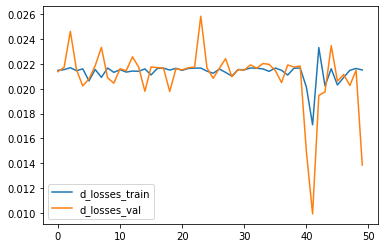

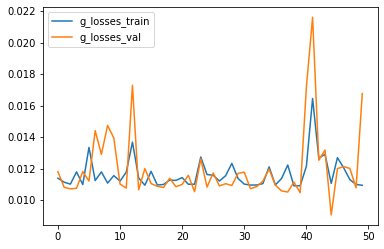

In [22]:
import matplotlib.pyplot as plt

plt.plot(gan.d_losses_train, label='d_losses_train')
plt.plot(gan.d_losses_val, label='d_losses_val')
plt.legend()
plt.show()

plt.plot(gan.g_losses_train, label='g_losses_train')
plt.plot(gan.g_losses_val, label='g_losses_val')
plt.legend()
plt.show()

In [95]:
Z_SAMPLE_COUNT = 32

## TODO: Move into StructuralCausalModel
def predict(scm, x, gan, device='cuda'):
    x_dup = torch.repeat_interleave(x, Z_SAMPLE_COUNT, dim=0)
    z_samples = gan.drawsamples(N=len(x_dup), get_tensor=True)

    # x_dup = x_dup.to(device)
    # z_samples = z_samples.to(device)

    with torch.no_grad():
        x_feat = model.text_featurizer(x_dup)
        y_pred_logits = model.pthetay_xz(x_feat, z_samples).reshape((x.size(0), Z_SAMPLE_COUNT, -1)).mean(dim=1)

    return nn.functional.sigmoid(y_pred_logits)


In [96]:
predict(model, X_train_tensor[:64].cuda(), gan).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([64, 1])

In [97]:
def predict_dataset(model, X_test, gan, batch_size=256):

    model.eval()

    with torch.no_grad():

        test_size = X_test.shape[0]
        test_preds = torch.zeros((test_size, ))

        for batch in range(0, test_size, batch_size):

            start_index = batch
            end_index = min(batch + batch_size, test_size)

            batch_X = X_test[start_index:end_index].cuda()

            output = predict(model, batch_X, gan)

            test_preds[start_index:end_index] = output.squeeze(dim=1).cpu()

    model.train()

    return test_preds

In [98]:
pred_test = predict_dataset(model, X_test_tensor, gan)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [99]:
# pred_test = predict_dataset(model, X_test_tensor, gan)
y_pred = np.round(pred_test.cpu().numpy())

print("Accuracy: {}".format(accuracy_score(test_df['label'], y_pred)))

Accuracy: 0.7383


In [100]:
dataset_index

1